# <span style="color:steelblue">Clasificación reseña restaurantes y analísis de sentimiento</span>

Hecho por: Daniel Piñeres y Maria Paula Alvarez 

Fecha: 2024-04-26


Librerias

In [41]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from wordcloud import WordCloud
import plotly.graph_objs as go
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize

In [2]:
df = pd.read_csv("RestaurantsReview.csv")

In [3]:
df.head(3)

,ID restaurante,nombre restaurante,calificacion,latitud,longitud,resena
0,ChIJQSu9Vk0s9I4RsNvqVcZdBsk,Crepes & Waffles Buena Vista,2,11.013606,-74.82767,"We believe could be a bad restaurant election,..."
1,ChIJQSu9Vk0s9I4RsNvqVcZdBsk,Crepes & Waffles Buena Vista,3,11.013606,-74.82767,Have eaten at several Crepes & Waffles in othe...
2,ChIJQSu9Vk0s9I4RsNvqVcZdBsk,Crepes & Waffles Buena Vista,4,11.013606,-74.82767,I enjoy this place and the food is excellent.\...


In [4]:
df.shape

(27000, 6)

La información corresponde a 27.000 reseñas y calificación de lo usuarios de Google Maps sobre los restaurantes del sector Buenavista en Barranquilla, Atlántico, Colombia.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID restaurante      27000 non-null  object 
 1   nombre restaurante  27000 non-null  object 
 2   calificacion        27000 non-null  int64  
 3   latitud             27000 non-null  float64
 4   longitud            27000 non-null  float64
 5   resena              25800 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


*   ID restaurante: Identificador único del restaurante. Tipo texto.
*   nombre resturante: Nombre del restaurante. Tipo texto.
*   calificacion: Valoración del restaurante de 1 - 5 . Tipo númerico discreto.
*   latitud: Coordenada de latitud de la ubicación. Tipo númerico.
*   longuitud: Coorndeada de longitud de la ubicación. Tipo númerico.
*   resena: Descripción de la experiencia y valoración del usuario sobre el restaurante.

In [6]:
len(df["nombre restaurante"].unique())

19

Revisión de faltantes

In [7]:
missing_reviews = (df["resena"].isnull().sum() / len(df["resena"]))*100
missing_reviews

4.444444444444445

In [8]:
df.describe()

,calificacion,latitud,longitud
count,27000.000000,27000.000000,27000.000000
mean,3.744444,11.014272,-74.827408
std,1.457278,0.000955,0.000681
min,1.000000,11.012497,-74.828370
25%,3.000000,11.013606,-74.827778
50%,4.000000,11.014577,-74.827705
75%,5.000000,11.015071,-74.826716
max,5.000000,11.015337,-74.826097


Procederemos a revisar la información faltante en los datos.

In [9]:
df["nombre restaurante"].unique()

array(['Crepes & Waffles Buena Vista', 'Subway',
       'Restaurante y repostería Nancy Cabrera', 'Donde Mama',
       'Burger King Buenavista', 'M Cocina Árabe Sede Plaza del Parque',
       "Shakin' Burgers and Shakes", 'Centro Comercial Plaza del Parque',
       'El Punto Múltiple del Sabor - Hot / C.C Plaza del Parque',
       'Kokoriko Buenavista', 'La Terraza De La Casa Buenavista',
       'La Diva, CC Buenavista 2, Baq',
       'Frisby Centro Comercial Buenavista 2',
       'Sándwich Qbano Buenavista', 'Frisby Buenavista',
       'Checkin chicken', 'Archies Mall Plaza - Barranquilla',
       "L'America sede Mall Plaza",
       'El Punto Múltiple del Sabor - Hot / C.C Mall Plaza'], dtype=object)

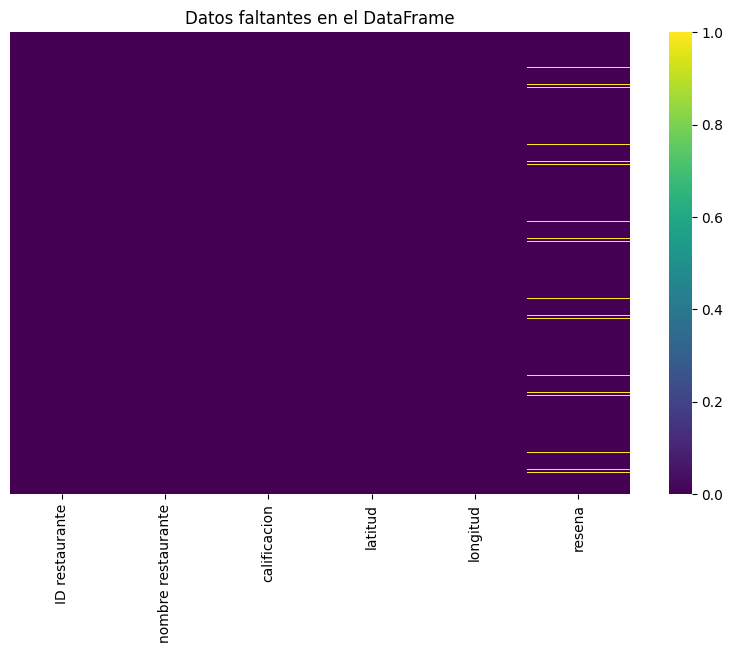

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=True, yticklabels=False)
plt.title('Datos faltantes en el DataFrame')
plt.show()

In [11]:
missing_reviews = df['resena'].isnull().sum()
total_reviews = len(df['resena'])
missing_rate = missing_reviews / total_reviews * 100
print(f"Proporción de faltantes en la columna 'Review': {missing_rate:.2f}%")


Proporción de faltantes en la columna 'Review': 4.44%


Observamos que la única variable con información faltante corresponde a las reseñas, con solamente un 4.45%.

Se analizarán 27 restaurantes. El promedio general de las calificaciones corresponde a 3.77

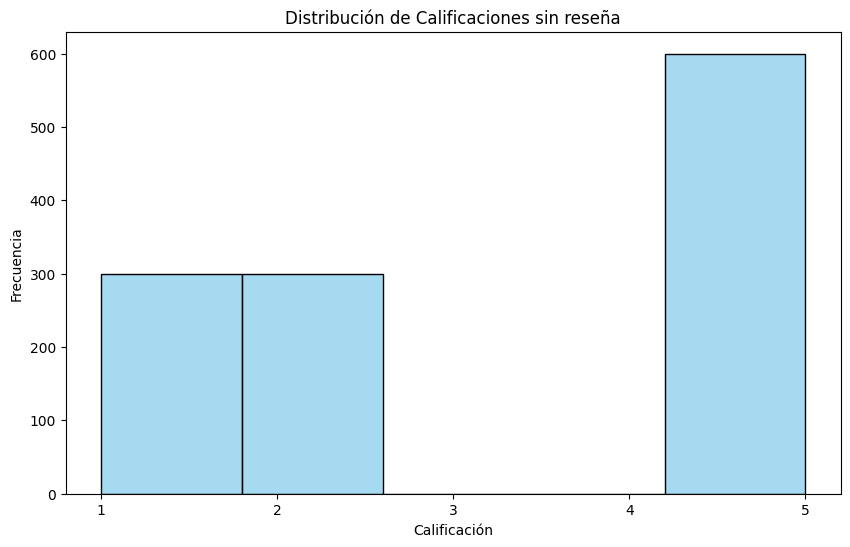

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['resena'].isnull()]['calificacion'], color='skyblue', bins = 5)
plt.title('Distribución de Calificaciones sin reseña')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

Las principales reseñas vacias corresponden a calificaciones muy altas o muy bajas.

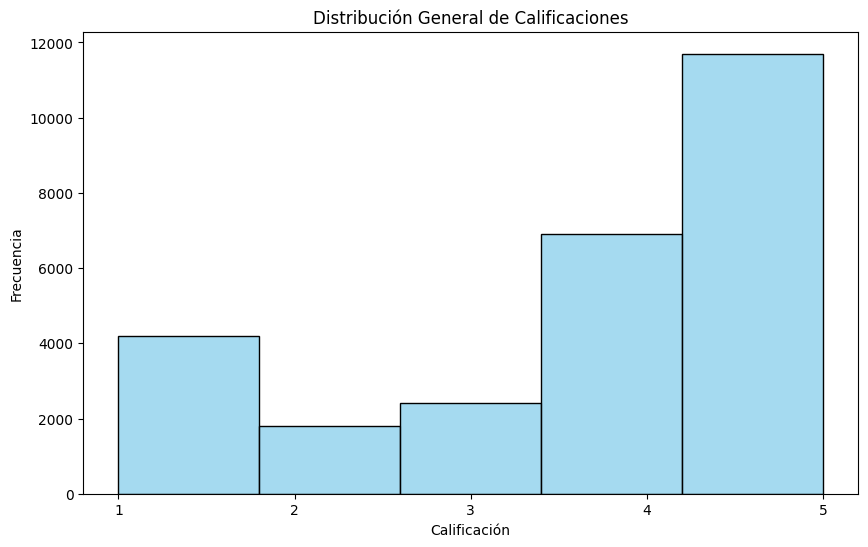

In [13]:
# Gráfico de distribución general de calificaciones
plt.figure(figsize=(10, 6))
sns.histplot(df['calificacion'], color='skyblue', bins = 5)
plt.title('Distribución General de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

La mayoría de las calificaciones corresponde a 4 y 5. Por otro lado, se evidencia un desbalanceo en los datos puesto que las proporciones de 2,3 son bastante inferiores con respecto a las otras catgorías.

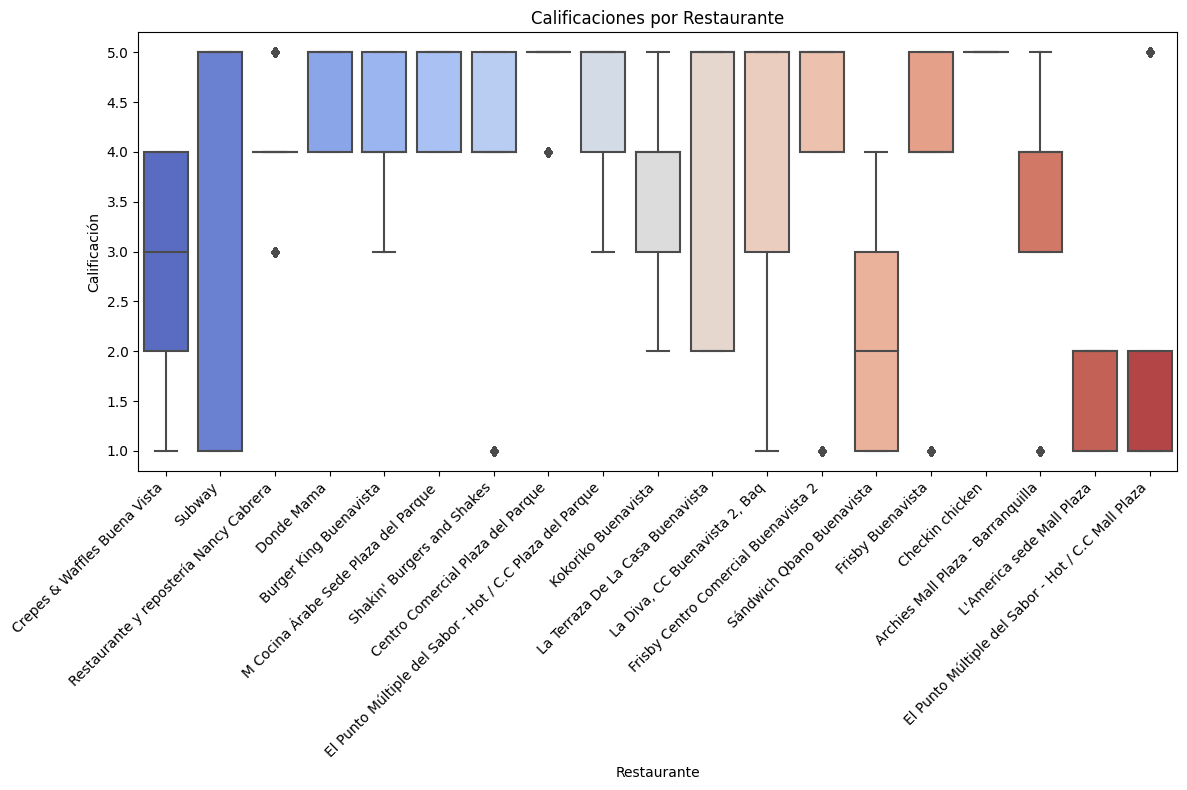

In [14]:
# Gráfico de calificaciones por restaurante
plt.figure(figsize=(12, 8))
sns.boxplot(x='nombre restaurante', y='calificacion', data=df, palette='coolwarm')
plt.title('Calificaciones por Restaurante')
plt.xlabel('Restaurante')
plt.ylabel('Calificación')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Se aprecia que algunos restaurantes como Subway presentan una alta desviación. Por otro lado, hay restaurantes con calificaciones únicamente positivas y otras con calificaciones únicamente negativas.

In [15]:
promedio_calificaciones = df.groupby('nombre restaurante')['calificacion'].mean().reset_index()

# Obtener valores únicos de nombre de restaurante, latitud y longitud
restaurantes_unicos = df.drop_duplicates(subset=['nombre restaurante', 'latitud', 'longitud'])

# Unir el DataFrame de valores únicos con el promedio de calificaciones
tabla = pd.merge(restaurantes_unicos, promedio_calificaciones, on='nombre restaurante', how='left')


In [16]:
tabla.head(2)

,ID restaurante,nombre restaurante,calificacion_x,latitud,longitud,resena,calificacion_y
0,ChIJQSu9Vk0s9I4RsNvqVcZdBsk,Crepes & Waffles Buena Vista,2,11.013606,-74.827670,"We believe could be a bad restaurant election,...",2.8
1,ChIJGePiO00s9I4R1NcsfxULHYA,Subway,1,11.014577,-74.827538,"Today, Nov 29/23, we arrived at 8.30pm, they t...",3.4


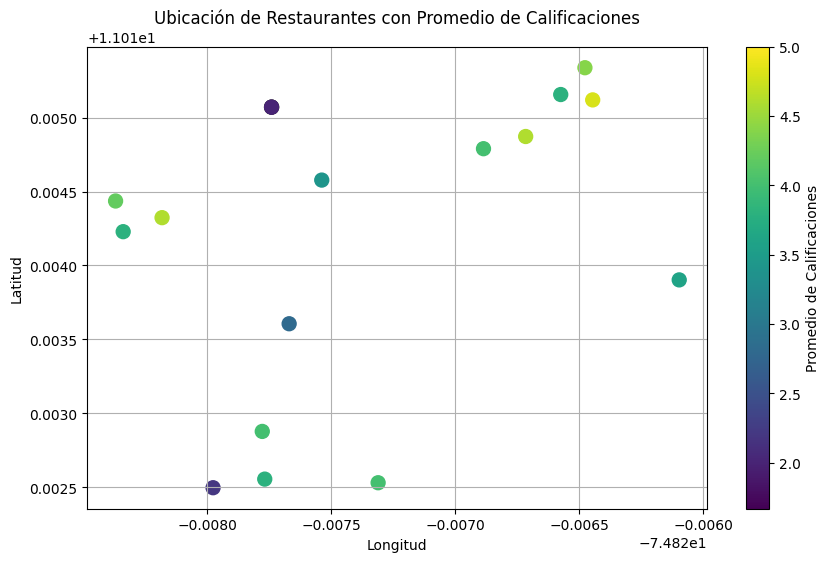

In [17]:
# Graficar los puntos con el promedio de calificaciones como color
plt.figure(figsize=(10, 6))
plt.scatter(tabla['longitud'], tabla['latitud'], c=tabla['calificacion_y'], cmap='viridis', s=100)
plt.colorbar(label='Promedio de Calificaciones')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Ubicación de Restaurantes con Promedio de Calificaciones')
plt.grid(True)
plt.show()

Se aprecia una concentración de restaurantes con calificaciones altas en un mismo sector.

In [18]:
import plotly.express as px

# Calcular el promedio de calificaciones y el conteo de reseñas por ubicación
restaurantes_agrupados = df.groupby(['latitud', 'longitud']).agg({'calificacion': ['mean', 'count'], 'nombre restaurante': 'first'}).reset_index()
restaurantes_agrupados.columns = ['latitud', 'longitud', 'promedio_calificacion', 'conteo_reseñas', 'nombre_restaurante']

# Crear el mapa con Plotly Express
fig = px.scatter_mapbox(restaurantes_agrupados,
                     lat='latitud',
                     lon='longitud',
                     size='conteo_reseñas',
                     color='promedio_calificacion',
                     hover_name='nombre_restaurante',
                     hover_data={'promedio_calificacion': True, 'conteo_reseñas': True, 'latitud': False, 'longitud': False},
                     size_max=45,
                     color_continuous_scale=px.colors.sequential.Viridis)

# Configurar el diseño del mapa
fig.update_layout(title_text='Mapa de Restaurantes con Promedio de Calificaciones y Conteo de Reseñas',
                  mapbox=dict(
                      style="open-street-map",
                      center=dict(lat=restaurantes_agrupados['latitud'].mean(), lon=restaurantes_agrupados['longitud'].mean()),
                      zoom=15.5),
                  )
fig.show()


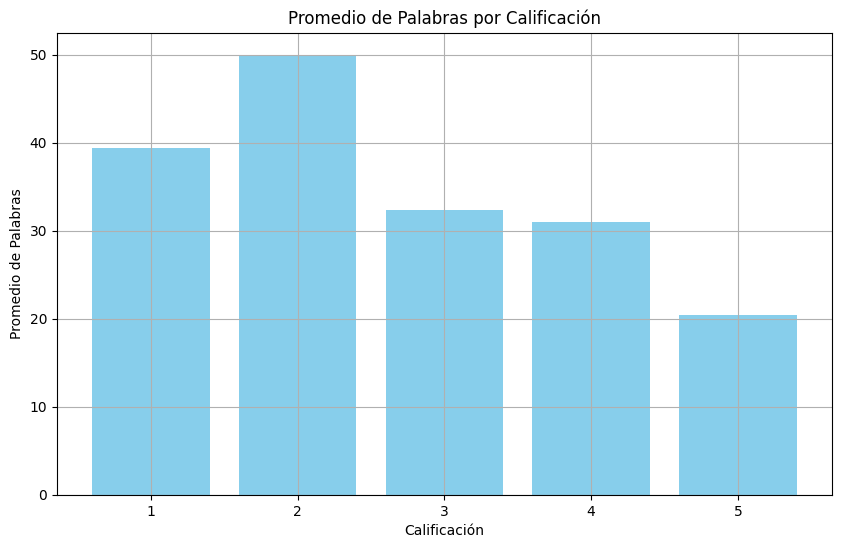

In [19]:
# Filtrar las reseñas que no son NaN
df_filtered = df.dropna(subset=['resena'])

# Calcular la cantidad promedio de palabras por calificación
promedio_palabras_por_calificacion = df_filtered.groupby('calificacion')['resena'].apply(lambda x: x.str.split().apply(len).mean()).reset_index()
promedio_palabras_por_calificacion.columns = ['calificacion', 'promedio_palabras']

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(promedio_palabras_por_calificacion['calificacion'], promedio_palabras_por_calificacion['promedio_palabras'], color='skyblue')
plt.title('Promedio de Palabras por Calificación')
plt.xlabel('Calificación')
plt.ylabel('Promedio de Palabras')
plt.xticks(promedio_palabras_por_calificacion['calificacion'])
plt.grid(True)
plt.show()



Las calificaciones bajas de 1 y 2 son aquellas que tienden a tener frases más largas, esto tiene sentido puesto que expresarán los motivos negativos de su experiencia.

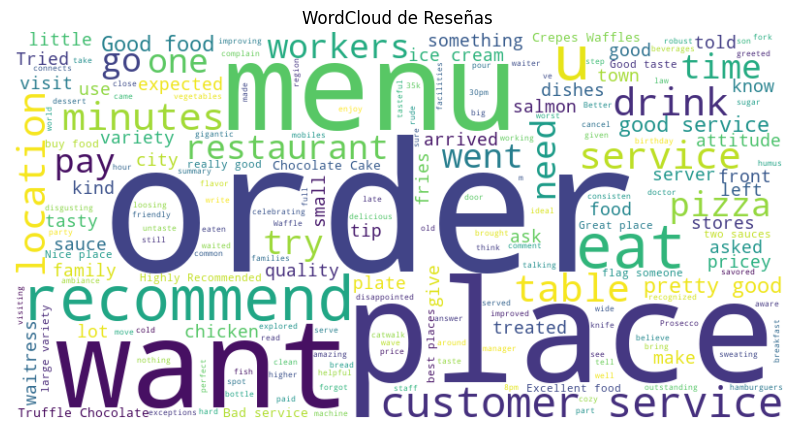

In [20]:
texto_resenas = ' '.join(df['resena'].dropna())

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_resenas)

# Mostrar el WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud de Reseñas')
plt.axis('off')
plt.show()

Las palabras más comunes son orden, lugar, servicio al cliente y palabras relacionadas con comida.

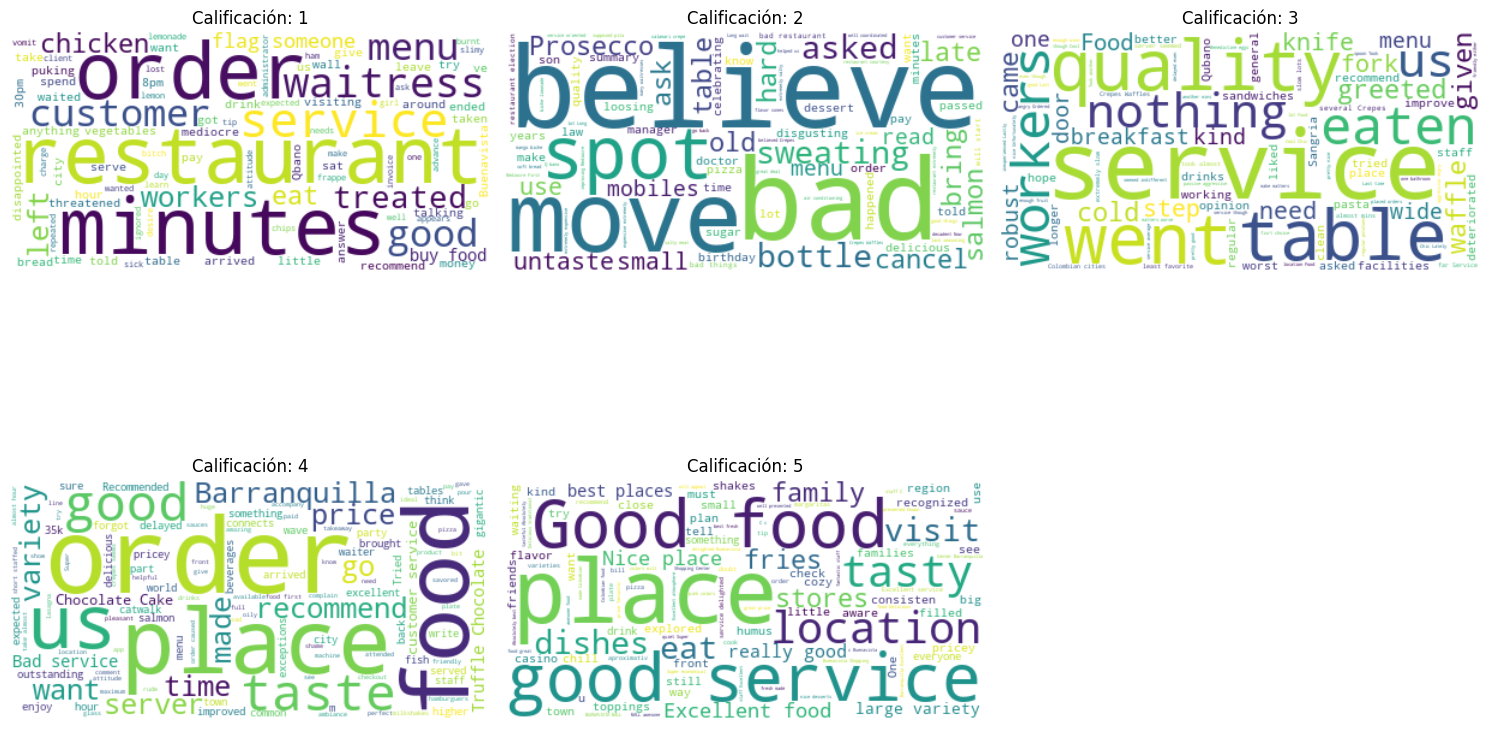

In [21]:
# Configurar el tamaño del grid y el tamaño de la figura
num_rows = 2
num_cols = 3
plt.figure(figsize=(15, 10))

# Iterar sobre cada calificación
for i, calificacion in enumerate(range(1, 6), start=1):
    # Filtrar las reseñas para la calificación actual
    reseñas_calificacion = df[df['calificacion'] == calificacion]['resena'].dropna()

    # Concatenar las reseñas en una sola cadena
    texto_reseñas = ' '.join(reseñas_calificacion)

    # Crear el WordCloud para la calificación actual
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(texto_reseñas)

    # Mostrar el WordCloud en el subplot correspondiente
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Calificación: {}'.format(calificacion))
    plt.axis('off')

# Ajustar el diseño y mostrar el grid de WordClouds
plt.tight_layout()
plt.show()


### Análisis de sentimiento

In [22]:
def clasificar_sentimiento(polaridad):
    if polaridad > 0.1:
        return 'Positivo'
    elif polaridad < -0.1:
        return 'Negativo'
    else:
        return 'Neutral'

# Función para realizar análisis de sentimiento en una reseña
def analizar_sentimiento(texto):
    # Crear un objeto TextBlob con el texto de la reseña
    blob = TextBlob(texto)
    # Calcular la polaridad del sentimiento (valor entre -1 y 1)
    polaridad = blob.sentiment.polarity
    clasificacion = clasificar_sentimiento(polaridad)
    # Devolver tanto la polaridad como la clasificación del sentimiento
    return polaridad, clasificacion

In [23]:
df['resena'] = df['resena'].astype(str)
# Aplicar la función de análisis de sentimiento a cada reseña y guardar los resultados en nuevas columnas
df['polaridad'], df['clasificacion'] = zip(*df['resena'].apply(analizar_sentimiento))

# Mostrar el DataFrame con las nuevas columnas de polaridad y clasificación del sentimiento
print(df[['resena', 'polaridad', 'clasificacion']])

                                                  resena     polaridad  \
0      We believe could be a bad restaurant election,...  6.410256e-03   
1      Have eaten at several Crepes & Waffles in othe... -1.805556e-01   
2      I enjoy this place and the food is excellent.\...  1.072650e-01   
3                          Bad service.  Good ice cream.  5.551115e-17   
4      Really disappointed with the service at the re... -4.633333e-01   
...                                                  ...           ...   
26995                                                nan  0.000000e+00   
26996  Today I wanted to buy food. but the waitress h... -1.000000e+00   
26997  They charge a “tip” in advance and without let...  0.000000e+00   
26998  I left the girl's purse and there is no contac...  0.000000e+00   
26999                                                nan  0.000000e+00   

      clasificacion  
0           Neutral  
1          Negativo  
2          Positivo  
3           Neutral  
4

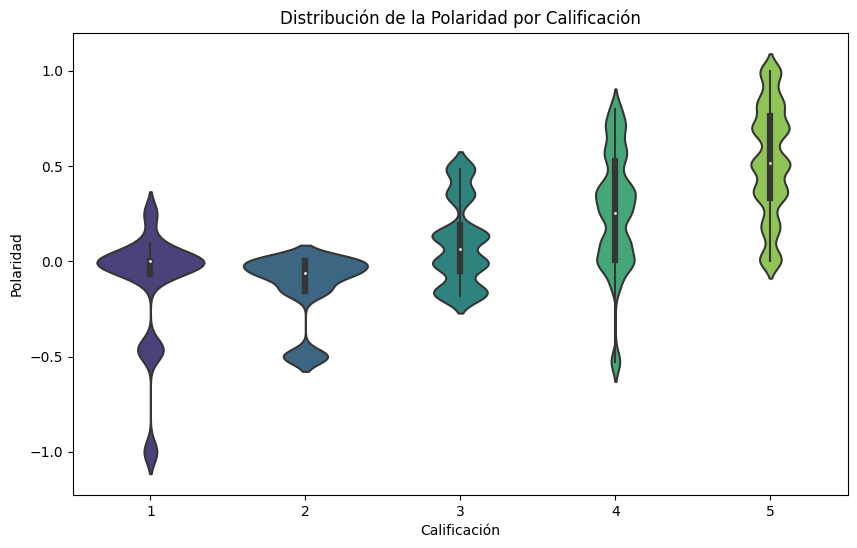

In [24]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='calificacion', y='polaridad', data=df, palette='viridis')
plt.title('Distribución de la Polaridad por Calificación')
plt.xlabel('Calificación')
plt.ylabel('Polaridad')
plt.show()


Se observa que a medida que la polaridad aumenta, así también aumenta las calificaciones. Se evidencian algunos datos atípicos para la calificación de 4. Vamos a revisarlo.

In [25]:
df_filtered = df[df['calificacion'] == 4].sort_values(by='polaridad', ascending=True)
# Seleccionar las columnas deseadas
df_filtered[['nombre restaurante', 'resena', 'polaridad', 'clasificacion']].head(1)

,nombre restaurante,resena,polaridad,clasificacion
25989,Frisby Buenavista,Bad service. Lousy salad. I ordered chicken fo...,-0.526154,Negativo


Esta reseña en particular indica un descontento del usuario con el servicio, y se esperaría una mala calificación, sin embargo, la calificación fue positiva de 4.

Mostraremos más ejemplos del sentimiento.

In [26]:
df_filtered = df[df["clasificacion"]=="Positivo"]
df_filtered[['nombre restaurante', "calificacion", 'resena', 'polaridad', 'clasificacion']].head(3)

,nombre restaurante,calificacion,resena,polaridad,clasificacion
2,Crepes & Waffles Buena Vista,4,I enjoy this place and the food is excellent.\...,0.107265,Positivo
7,Subway,5,"Excellent service, delighted",0.850000,Positivo
8,Subway,5,Buenavista Shopping Center (Barranquilla) Exce...,0.160000,Positivo


In [27]:
df_filtered = df[df["clasificacion"]=="Neutro"]
df_filtered[['nombre restaurante', "calificacion", 'resena', 'polaridad', 'clasificacion']].head(3)

,nombre restaurante,calificacion,resena,polaridad,clasificacion


*Es neutro ocurre cuando no hay reseña

### Elimando stopwords

In [28]:
# Descargar las stopwords si no las tienes
nltk.download('stopwords')

# Obtener las stopwords en español
stop_words = set(stopwords.words('english'))

# Función para eliminar las stopwords de un texto
def eliminar_stopwords(texto):
    palabras = texto.split()  # Dividir el texto en palabras
    palabras_filtradas = [palabra for palabra in palabras if palabra.lower() not in stop_words]  # Filtrar las palabras que no son stopwords
    texto_filtrado = ' '.join(palabras_filtradas)  # Unir las palabras filtradas en un nuevo texto
    return texto_filtrado

# Aplicar la función de eliminación de stopwords a la columna de reseñas
df['resena_sin_stopwords'] = df['resena'].apply(eliminar_stopwords)


In [29]:
def lower(resena):
    low_text= resena.lower()
    return low_text
df['resena_new']=df['resena'].apply(lambda x:lower(x))


# Number removal
def remove_num(resena_sin_stopwords):
    remove= re.sub(r'\d+', '', resena_sin_stopwords)
    return remove
df['resena']=df['resena_new'].apply(lambda x:remove_num(x))

In [30]:
tfidf_vectorizer = TfidfVectorizer()

In [31]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['resena_new'])

In [32]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [33]:
tfidf_df

,10,100,15,18,1h,23,29,30,30pm,32,...,working,world,worse,worst,would,write,years,yesterday,you,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106737,0.0,0.0,...,0.0,0.0,0.133334,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.123466,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
26996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144691,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
26997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
26998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, df["calificacion"], test_size=0.2, random_state=42)

In [38]:
y_test = y_test.dropna()
x_test = x_test.loc[y_test.index]

In [39]:
y_test = y_test.astype(int)
y_train = y_train.astype(int)


Modelado

In [42]:
# Define models and expanded parameters
models = {
    "XGBoost": (xgb.XGBClassifier(eval_metric='logloss'), {
        'classifier__max_depth': [3, 4, 5],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__gamma': [0, 0.1, 0.2],
        'classifier__subsample': [0.5, 0.75, 1]
    }),
    "MLP": (MLPClassifier(max_iter=5000), {
        'classifier__hidden_layer_sizes': [(10,), (50,), (100,)],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__learning_rate_init': [0.001, 0.01, 0.1]
    })
}

results_df = pd.DataFrame()


# Adjusting labels to start from 0 if they start from 1
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

results_df = pd.DataFrame()


for model_name, (model, params) in models.items():
    print(f"Training model: {model_name}")
    pipe = SkPipeline([
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grid=params, cv=StratifiedKFold(5), n_jobs=-1, scoring='roc_auc_ovr')

    grid.fit(x_train, y_train_adjusted)
    y_pred = grid.predict(x_test)
    y_prob = grid.predict_proba(x_test)

    y_test_binarized = label_binarize(y_test_adjusted, classes=np.unique(y_train_adjusted))
    precision = precision_score(y_test_adjusted, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_test_adjusted, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_test_adjusted, y_pred, average='macro')
    auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')

    result = {
        "Model": model_name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Best Parameters": grid.best_params_,
        "Test Set Score": grid.score(x_test, y_test_adjusted)
    }
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

print(results_df)


Training model: XGBoost
Training model: MLP
     Model  Precision    Recall  F1-Score       AUC  \
0  XGBoost   0.987475  0.952929  0.968795  0.998813   
1      MLP   0.987475  0.952929  0.968795  0.998813   

                                     Best Parameters  Test Set Score  
0  {'classifier__gamma': 0, 'classifier__learning...        0.998813  
1  {'classifier__alpha': 0.0001, 'classifier__hid...        0.998813  


In [45]:
import pandas as pd

# Adjusting pandas display settings
pd.set_option('display.max_colwidth', None)  # This will ensure that the full content of each column is displayed
pd.set_option('display.width', 1000)  # Adjust the width to fit your screen or preference
pd.set_option('display.max_columns', 10)  # Adjust based on how many columns you expect

# Assuming results_df is your DataFrame that contains the results including 'Best Parameters'
print(results_df)


     Model  Precision    Recall  F1-Score       AUC                                                                                                                                          Best Parameters  Test Set Score
0  XGBoost   0.987475  0.952929  0.968795  0.998813  {'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 0.75}        0.998813
1      MLP   0.987475  0.952929  0.968795  0.998813                                            {'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1}        0.998813


Training model: XGBoost


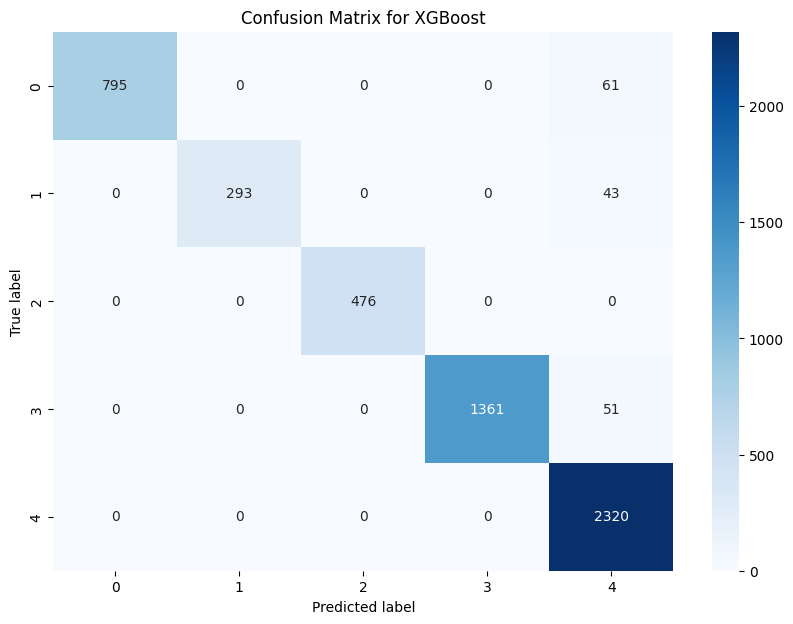

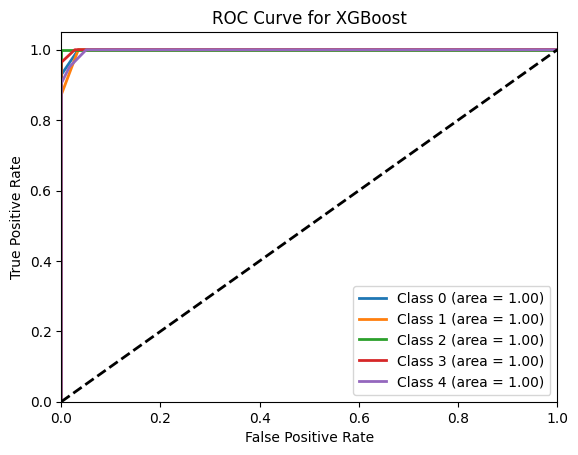

Training model: MLP


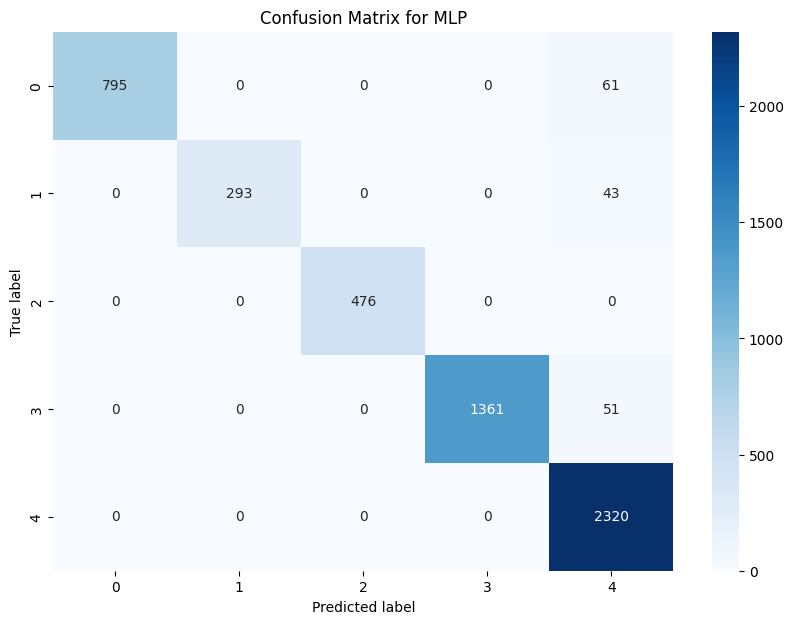

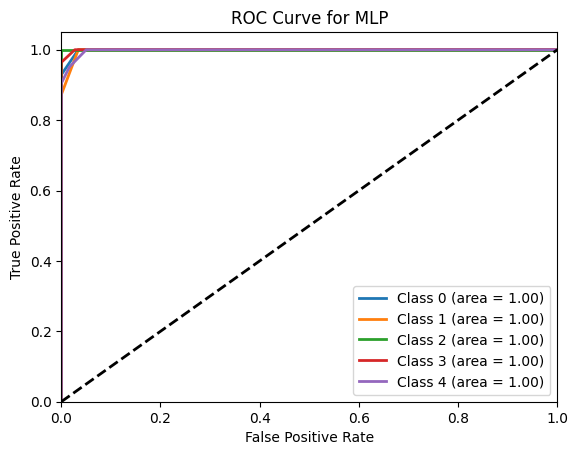

     Model  Precision    Recall  F1-Score       AUC
0  XGBoost   0.987475  0.952929  0.968795  0.998813
1      MLP   0.987475  0.952929  0.968795  0.998813


In [47]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

models = {
    "XGBoost": xgb.XGBClassifier(
        eval_metric='logloss',
        gamma=0,
        learning_rate=0.01,
        max_depth=5,
        n_estimators=300,
        subsample=0.75
    ),
    "MLP": MLPClassifier(
        max_iter=5000,
        alpha=0.0001,
        hidden_layer_sizes=(10,),
        learning_rate_init=0.1
    )
}

results_df = pd.DataFrame()

for model_name, model in models.items():
    print(f"Training model: {model_name}")
    model.fit(x_train, y_train_adjusted)
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    # Metrics
    precision = precision_score(y_test_adjusted, y_pred, average='macro')
    recall = recall_score(y_test_adjusted, y_pred, average='macro')
    f1 = f1_score(y_test_adjusted, y_pred, average='macro')
    auc_score = roc_auc_score(label_binarize(y_test_adjusted, classes=np.unique(y_train_adjusted)), y_prob, multi_class='ovr')

    # Confusion Matrix
    cm = confusion_matrix(y_test_adjusted, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    y_test_bin = label_binarize(y_test_adjusted, classes=np.unique(y_train_adjusted))
    n_classes = y_test_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Store results
    result = {
        "Model": model_name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc_score
    }
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

print(results_df)

XGBoost:
Precisión: 0.987 (muy alta).
Recall: 0.953 (buena capacidad para encontrar verdaderos positivos).
F1-Score: 0.969 (un buen equilibrio entre precisión y recall).
AUC: 0.999 (excelente capacidad de clasificación).
Los mejores hiperparámetros incluyen un gamma de 0, una tasa de aprendizaje de 0.01, una profundidad máxima de 5 y 300 estimadores.
La puntuación en el conjunto de prueba es del 99.88%.
MLP (Perceptrón Multicapa):
Los resultados son idénticos a los de XGBoost.
Los mejores hiperparámetros incluyen un alpha de 0.0001, una capa oculta con 10 neuronas y una tasa de aprendizaje inicial de 0.1.
La puntuación en el conjunto de prueba también es del 99.88%.